In [1]:
import os
import cv2
import itertools
import librosa
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import warnings
import zipfile
# from pydub import AudioSegment
from tqdm import tqdm
from glob import glob
from PIL import Image
from google.colab import files
from google.cloud import storage
warnings.filterwarnings('ignore')

# Pytorch
import torch
import torchaudio
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchaudio.transforms import MelSpectrogram, MFCC, SpectralCentroid

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pacotes para o relatório de hardware
import gc
import types
import pkg_resources
# import pytorch_lightning as pl

# Seed para reproduzir os mesmos resultados
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
device = 'cuda'

In [ ]:
# !find /content/sample_data/ -type f -exec rm {} +

### Import Data

In [3]:
firts_time = True

In [4]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [6]:
storage_client = storage.Client()

In [7]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_data.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [8]:
import zipfile

In [9]:
with zipfile.ZipFile('audio_data.zip', 'r') as zip_ref:
    # Extraindo todos os arquivos
    zip_ref.extractall('/content')

### Import dos dados e cálculo do desvio

In [10]:
labels = pd.read_csv('audio_data.csv')
labels.drop(columns='Unnamed: 0',inplace=True)

In [11]:
labels

,file_path,chord_idx
0,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
2,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
4,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
...,...,...
1176055,chords/variation_chord_audio_world_noise/t_DsG...,369
1176056,chords/variation_chord_audio_world_noise/t_DsG...,369
1176057,chords/variation_chord_audio_world_noise/t_DsG...,369
1176058,chords/variation_chord_audio_world_noise/t_DsG...,369


In [12]:
analise = labels['chord_idx'].value_counts()
analise

186    6501
20     6438
303    6285
109    6278
149    6058
       ... 
227    1260
120    1242
169    1240
92     1240
197    1134
Name: chord_idx, Length: 373, dtype: int64

In [13]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 3152.98
Percentil 25: 2499.0
Mediana: 3093.0
Percentil 75: 3670.0
Desvio Padrão: 934.84
Moda: 0    2310
Name: chord_idx, dtype: int64
Max: 6501
Min: 1134


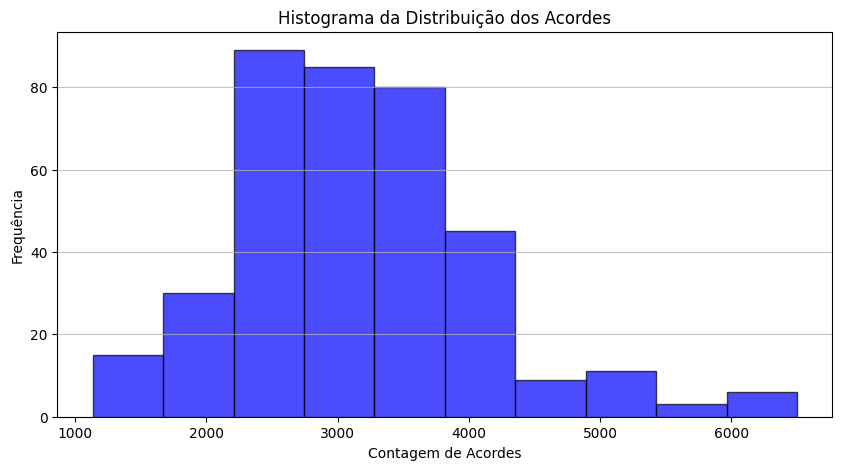

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
target_instance = analise.quantile(0.6)
target_std = round(analise.std(),0)
# data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x),0) if x > target_instance else 0)
data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x) * 1.4,0) if x > target_instance else 0)

In [16]:
for label, group in labels.groupby('chord_idx'):
    rate = data_aug_rate_down[label]
    if rate > 0:
        # Seleciona aleatoriamente 'rate' amostras para remover
        samples_to_remove = group.sample(n=int(rate))
        # Remove as amostras selecionadas do dataframe original
        labels = labels.drop(samples_to_remove.index)

labels.reset_index(drop=True, inplace=True)

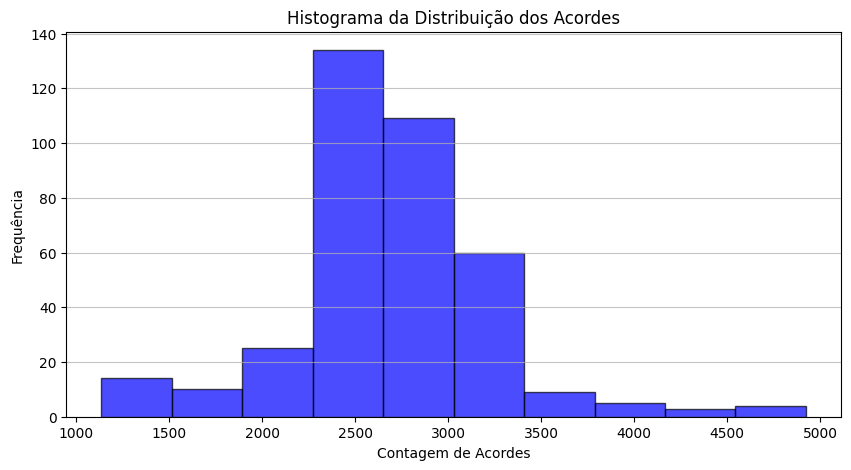

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(labels['chord_idx'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
transforms_dict = {
    'mel_spectrogram': torchaudio.transforms.MelSpectrogram(sample_rate=22050),
    'mfcc': torchaudio.transforms.MFCC(sample_rate=22050),
    'spectral': torchaudio.transforms.SpectralCentroid(sample_rate=22050),
    'chroma': lambda x: torch.tensor(librosa.feature.chroma_stft(y=x.numpy(), sr=22050)),
    'tonnetz': lambda x: torch.tensor(librosa.feature.tonnetz(y=x.numpy(), sr=22050)),
}

In [ ]:
def calculate_feature_statistics(audio_paths, feature_type):
    assert feature_type in transforms_dict, f"Feature {feature_type} is not supported."
    transform = transforms_dict[feature_type]
    sum_of_features = None
    sum_of_features_squared = None
    num_features = 0

    for path in tqdm(audio_paths):
        try:
            waveform, sample_rate = torchaudio.load(path)
            if callable(transform):
                feature = transform(waveform.squeeze(0))
            else:
                feature = transform(waveform)

            if not isinstance(feature, torch.Tensor):
                feature = torch.from_numpy(np.array(feature))

            feature_mean = feature.mean(dim=-1)
            feature_squared_mean = (feature ** 2).mean(dim=-1)

            if sum_of_features is None:
                sum_of_features = torch.zeros_like(feature_mean)
                sum_of_features_squared = torch.zeros_like(feature_mean)

            sum_of_features += feature_mean
            sum_of_features_squared += feature_squared_mean
            num_features += 1

        except RuntimeError as e:
            print(f"Failed to process {path}: {e}")

    if num_features == 0:
        raise ValueError("No features were processed. Please check your audio files and paths.")

    mean = sum_of_features / num_features
    std = (sum_of_features_squared / num_features - mean ** 2).sqrt()

    return mean, std


In [ ]:
normMean, normStd = calculate_feature_statistics(labels['file_path'], 'mel_spectrogram')

 80%|███████▉  | 803859/1005677 [1:22:50<26:57, 124.78it/s]

Failed to process chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3: Failed to open the input "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3" (Invalid data found when processing input).
Failed to process chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3: Failed to open the input "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3" (Invalid data found when processing input).
Failed to process chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3: Failed to open the input "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum

100%|██████████| 1005677/1005677 [1:43:45<00:00, 161.54it/s]


In [19]:
normMean = [0.30298967, 0.11516446, 0.23933927]
normStd = [0.35485684, 0.16791199, 0.2177703 ]

In [ ]:
pd.DataFrame(normMean.numpy()).to_csv('media.csv', index=False)

In [ ]:
pd.DataFrame(normStd.numpy()).to_csv('desvio_pad.csv', index=False)

In [ ]:
normMean = torch.tensor(pd.read_csv('media.csv').values)
normStd = torch.tensor(pd.read_csv('desvio_pad.csv').values)

In [20]:
# Lista de arquivos com erro
files_with_error = [
    "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3",
    # Adicione mais caminhos de arquivos aqui, se necessário
]

# Remover as linhas do DataFrame que contêm os caminhos dos arquivos com erro
labels = labels[~labels['file_path'].isin(files_with_error)]


### Funções do modelo

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def inicializa_modelo(num_classes, feature_extract, use_pretrained=True):
    input_size = 224
    model_ft = models.densenet121(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    return model_ft

In [23]:
class AudioToImageDataset(Dataset):
    def __init__(self, df, audio_transforms=None, image_transforms=None):
        self.df = df
        self.audio_transforms = audio_transforms
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['chord_idx']
        waveform, sample_rate = torchaudio.load(audio_path)

        # Gera o espectrograma de mel
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)

        # Aplica as transformações de áudio
        if self.audio_transforms:
            mel_spectrogram = self.audio_transforms(mel_spectrogram)

        # Converte o espectrograma para o formato de imagem PIL
        mel_spectrogram = mel_spectrogram.repeat(3, 1, 1)  # Repete o espectrograma em 3 canais
        mel_spectrogram = mel_spectrogram.numpy()
        mel_spectrogram = np.transpose(mel_spectrogram, (1, 2, 0))  # Reordena as dimensões para HxWxC
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.min()) / (mel_spectrogram.max() - mel_spectrogram.min())  # Normaliza
        mel_spectrogram = Image.fromarray(np.uint8(mel_spectrogram * 255))  # Converte para imagem PIL

        # Aplica as transformações de imagem
        if self.image_transforms:
            mel_spectrogram = self.image_transforms(mel_spectrogram)

        return mel_spectrogram, label

In [24]:
# Função para calcular erro em treino e validação durante o treinamento
class CalculaMetricas(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [176]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]
total_iterations = 0  # Contador acumulativo de iterações
max_iterations = 2000  # Limite total de iterações

def treina_modelo(treino_loader, model, criterion, optimizer, epoch, device):
    global total_iterations
    model.train()

    train_loss = CalculaMetricas()
    train_acc = CalculaMetricas()

    for i, (spectrograms, labels) in enumerate(treino_loader):

        #if total_iterations > max_iterations:
        #    break

        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / spectrograms.size(0))
        train_loss.update(loss.item())


        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (epoch,
                                                                                       i + 1,
                                                                                       len(treino_loader),
                                                                                       train_loss.avg,
                                                                                       train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
        total_iterations += 1
    return train_loss.avg, train_acc.avg

In [177]:
total_loss_val, total_acc_val = [],[]
def valida_modelo(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = CalculaMetricas()
    val_acc = CalculaMetricas()

    with torch.no_grad():
        for i, (spectrograms, labels) in enumerate(val_loader):
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            outputs = model(spectrograms)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / spectrograms.size(0))
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[Epoch {epoch}], [Val Loss {val_loss.avg:.5f}], [Val Acc {val_acc.avg:.5f}]')
    print('------------------------------------------------------------')

    return val_loss.avg, val_acc.avg

### Editando dataset

In [27]:
y = labels['chord_idx']
_, df_validacao = train_test_split(labels, test_size = 0.2, random_state = 101, stratify = y)

In [28]:
df_validacao.shape

(201135, 2)

In [29]:
indices_validacao = set(df_validacao.index)

# Agora definimos uma função que verifica se o índice de uma linha está nesse conjunto
def get_train_val_label(row_index):
    return 'val' if row_index in indices_validacao else 'train'

# Aplicamos essa função a cada linha do DataFrame 'labels'
labels['train_or_val'] = labels.index.map(get_train_val_label)


In [30]:
labels[labels['train_or_val'] == 'train']

,file_path,chord_idx,train_or_val
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
5,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
8,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
10,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
...,...,...,...
1005672,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005673,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005674,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005675,chords/variation_chord_audio_world_noise/t_DsG...,369,train


In [31]:
# Filtra as linhas de treino
df_treino = labels[labels['train_or_val'] == 'train']

In [32]:
print(len(df_treino))
print(len(df_validacao))

804539
201135


In [33]:
df_treino['chord_idx'].value_counts()

186    3938
20     3893
303    3784
109    3778
149    3622
       ... 
227    1008
120     994
169     992
92      992
197     907
Name: chord_idx, Length: 373, dtype: int64

In [34]:
df_validacao['chord_idx'].value_counts()

186    985
20     973
303    946
109    945
149    906
      ... 
181    252
120    248
92     248
169    248
197    227
Name: chord_idx, Length: 373, dtype: int64

In [35]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_validacao, df_teste = train_test_split(df_validacao, test_size = 0.5)

In [36]:
# Reset do índice
df_validacao = df_validacao.reset_index()
df_teste = df_teste.reset_index()

In [37]:
df_validacao.shape

(100567, 3)

In [38]:
df_teste.shape

(100568, 3)

#### Inicializando modelo

In [ ]:
# Modelo que será treinado
# nome_modelo = 'densenet'
# nome_modelo = 'resnet'
# nome_modelo = 'inception'

In [179]:
num_classes = 373

In [188]:
feature_extract = False

In [190]:
model_ft = inicializa_modelo(num_classes, feature_extract, False)

In [191]:
model = model_ft.to(device)

In [192]:
import torchaudio.transforms as T

In [193]:
target_sample_rate = 22050

In [194]:
input_size = 224

In [195]:
audio_transform_train = transforms.Compose([
    #T.PitchShift(n_steps=30, n_fft=2048, sample_rate=target_sample_rate),
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=35),
    T.AmplitudeToDB(),
])

# Transformações de Imagem
image_transforms_train = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd)
])

In [196]:
audio_transforms_val = transforms.Compose([
    #T.PitchShift(n_steps=30, n_fft=2048, sample_rate=target_sample_rate),
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=35),
    T.AmplitudeToDB(),
])

# Transformações de Imagem para Validação
image_transforms_val = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd)
])

#### Carregando Dataloader

In [197]:
del set_treino, set_val, set_teste
del loader_treino, loader_val, loader_teste

In [198]:
# Organiza e transforma os dados de treino
set_treino = AudioToImageDataset(df_treino, audio_transforms=audio_transform_train, image_transforms=image_transforms_train)
loader_treino = DataLoader(set_treino, batch_size = 64, shuffle = True, num_workers = 4)

In [199]:
# O mesmo em validação
set_val = AudioToImageDataset(df_validacao, audio_transforms=audio_transforms_val, image_transforms=image_transforms_val)
loader_val = DataLoader(set_val, batch_size = 64, shuffle = False, num_workers = 4)

In [200]:
# O mesmo em teste
set_teste = AudioToImageDataset(df_teste, audio_transforms=audio_transforms_val, image_transforms=image_transforms_val)
loader_teste = DataLoader(set_teste, batch_size = 64, shuffle = False, num_workers = 4)

In [201]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [202]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

#### Treinamento

In [203]:
# Hiperparâmetros
epoch_num = 3
best_val_acc = 0

In [204]:
%%time
for epoch in range(1, epoch_num + 1):

    # Execute a função de treino
    loss_train, acc_train = treina_modelo(loader_treino, model, criterion, optimizer, epoch, device)

    # Executa a função de validação
    loss_val, acc_val = valida_modelo(loader_val, model, criterion, device, epoch)

    # Calcula as métricas
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # Verifica a acurácia em validação
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        torch.save(model.state_dict(), f'densenet_121_model_sec_{epoch}.pth')
    total_iterations = 0

[epoch 1], [iter 100 / 12571], [train loss 6.00040], [train acc 0.00328]
[epoch 1], [iter 200 / 12571], [train loss 5.95869], [train acc 0.00422]
[epoch 1], [iter 300 / 12571], [train loss 5.94550], [train acc 0.00354]
[epoch 1], [iter 400 / 12571], [train loss 5.93755], [train acc 0.00402]
[epoch 1], [iter 500 / 12571], [train loss 5.93178], [train acc 0.00416]
[epoch 1], [iter 600 / 12571], [train loss 5.92828], [train acc 0.00404]
[epoch 1], [iter 700 / 12571], [train loss 5.92556], [train acc 0.00402]
[epoch 1], [iter 800 / 12571], [train loss 5.92309], [train acc 0.00408]
[epoch 1], [iter 900 / 12571], [train loss 5.92086], [train acc 0.00399]
[epoch 1], [iter 1000 / 12571], [train loss 5.92031], [train acc 0.00413]
[epoch 1], [iter 1100 / 12571], [train loss 5.91832], [train acc 0.00419]
[epoch 1], [iter 1200 / 12571], [train loss 5.91713], [train acc 0.00417]
[epoch 1], [iter 1300 / 12571], [train loss 5.91617], [train acc 0.00427]
[epoch 1], [iter 1400 / 12571], [train loss 5.9

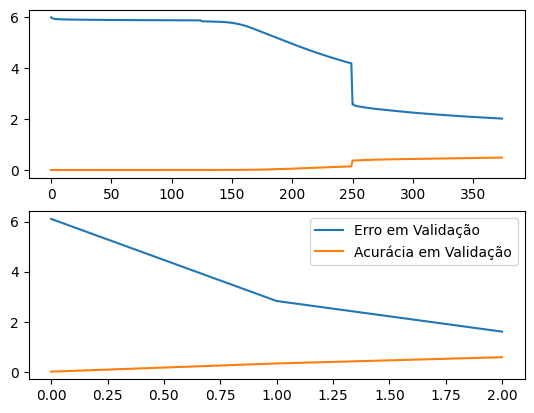

In [209]:
# Plot
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Erro em Treino')
fig1.plot(total_acc_train, label = 'Acurácia em Treino')
fig2.plot(total_loss_val, label = 'Erro em Validação')
fig2.plot(total_acc_val, label = 'Acurácia em Validação')
plt.legend()
plt.show()

In [207]:
# Função de plot da confusion_matrix
def plot_confusion_matrix(cm,
                          classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')

In [ ]:
# Avaliação do modelo com dados de teste
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(loader_teste):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim = True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

In [ ]:
# Cria a confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)

In [ ]:
# Plot da confusion matrix
plot_labels = labels['chord'].unique().tolist()
plot_confusion_matrix(confusion_mtx, plot_labels)